In [1]:
!pip install rarfile
!pip install pydot graphviz


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import datetime
import pydot
import graphviz


# ✅ Enable Mixed Precision for Faster Computation
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ✅ Enable XLA Compilation for Speed Optimization
tf.config.optimizer.set_jit(True)

# Print TensorFlow and NumPy versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.version.version}")
print("JIT Compilation Enabled 🚀")

TensorFlow Version: 2.17.1
NumPy Version: 1.26.4
JIT Compilation Enabled 🚀


In [3]:
# # Path to the .rar file in Google Drive
# rar_path = "/content/drive/MyDrive/80% of training image 224.rar"  # Change this path

# # Extract destination
# extract_path = "/content/drive/My Drive/80% of training image 224"  # Change this path if needed

# # Open and extract the .rar file
# with rarfile.RarFile(rar_path, 'r') as rar:
#     rar.extractall(extract_path)

# print("Extraction completed!")

In [4]:
from google.colab import drive
import pathlib

# Mount Google Drive
# drive.mount('/content/drive')

# Define the correct dataset path
data_dir = pathlib.Path('/kaggle/input/brain-tumor-mri-image-dataset/80 of training image with DAUG (5k Each Total 20k)/80% of training image with DAUG (5k Each, Total 20k)')

# Check if the path exists
if not data_dir.exists():
    print(f"Error: Directory {data_dir} does not exist. Check the path.")
else:
    print(f"Directory found: {data_dir}")

    # Count total images (considering multiple file formats)
    image_count = sum(len(list(folder.glob('*'))) for folder in data_dir.iterdir() if folder.is_dir())

    print("Total number of images:", image_count)

    # Get class names from the subdirectories
    CLASS_NAMES = [folder.name for folder in data_dir.iterdir() if folder.is_dir()]
    print("Class names:", CLASS_NAMES)

    # Determine the number of output units (classes)
    output_class_units = len(CLASS_NAMES)
    print("Number of output units:", output_class_units)


Directory found: /kaggle/input/brain-tumor-mri-image-dataset/80 of training image with DAUG (5k Each Total 20k)/80% of training image with DAUG (5k Each, Total 20k)
Total number of images: 20000
Class names: ['pituitary', 'notumor', 'meningioma', 'glioma']
Number of output units: 4


Found 20000 files belonging to 4 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv  

 Total params: 25,694,084 (98.02 MB)

 Trainable params: 2,104,324 (8.03 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 145ms/step - accuracy: 0.7888 - loss: 1.9074 - learning_rate: 0.0100
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.8967 - loss: 1.4760 - learning_rate: 0.0100
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.9109 - loss: 1.3213 - learning_rate: 0.0100
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.9176 - loss: 1.1908 - learning_rate: 0.0100
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9158 - loss: 1.0859 - learning_rate: 0.0100
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.9163 - loss: 0.9927 - learning_rate: 0.0100
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9143 - loss: 0.9247 - learning_rate: 0.0100
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.9150 - loss: 0.8575 - learning_rate: 0.0100
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.9169 - loss: 0.7859 - learn

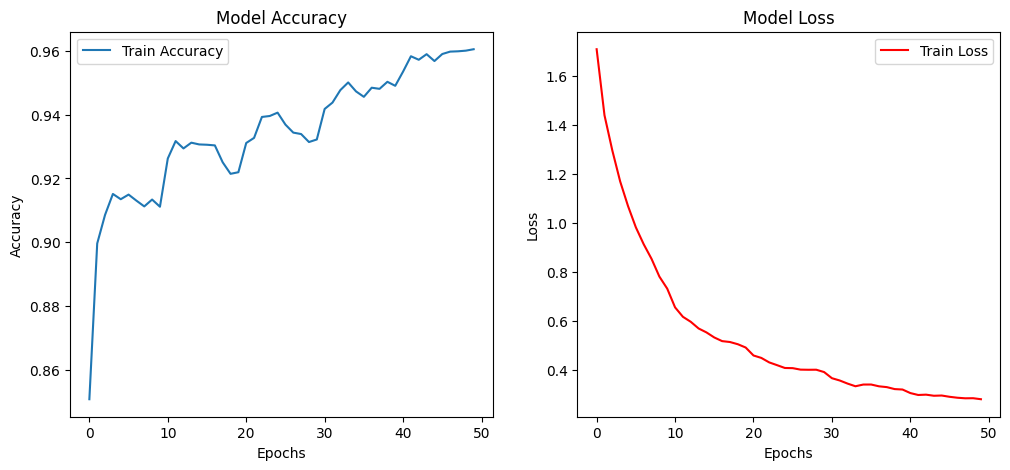

InvocationException: Program terminated with status: -6. stderr follows: failed at node 10646[1]
dot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.


In [5]:
# Define input shape parameters
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 4  # Adjust based on your dataset

# Load the dataset properly
train_data_gen = image_dataset_from_directory(
    directory=str(data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

# Apply preprocessing for ResNet50 & one-hot encode labels
train_data_gen = train_data_gen.map(lambda x, y: (preprocess_input(x), tf.one_hot(y, depth=NUM_CLASSES)))

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base model layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) # L2 Regularization
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
x = layers.BatchNormalization()(x)  # Batch Normalization for stability
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Define step decay function for learning rate scheduling
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** (epoch // epochs_drop))

# Compile the model with SGD optimizer and step decay learning rate scheduling
sgd_optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define TensorBoard and learning rate scheduler callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_scheduler = LearningRateScheduler(step_decay)

# Train the model
history = model.fit(
    train_data_gen,
    epochs=50,
    callbacks=[tensorboard_callback, lr_scheduler])

# Save the trained model
model.save('ResNet50_L2[0.001]_Dropout[0.5]_BN_LR[0.01]_OPT[SGD]_BS[64]_EP[50].h5')

# Visualize training history
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('training_history.png')
plt.show()

# Save the model architecture as an image
plot_model(model, to_file="model_architecture.png", show_shapes=True, dpi=50, expand_nested=False)
